# 전체 모델 구조 figure

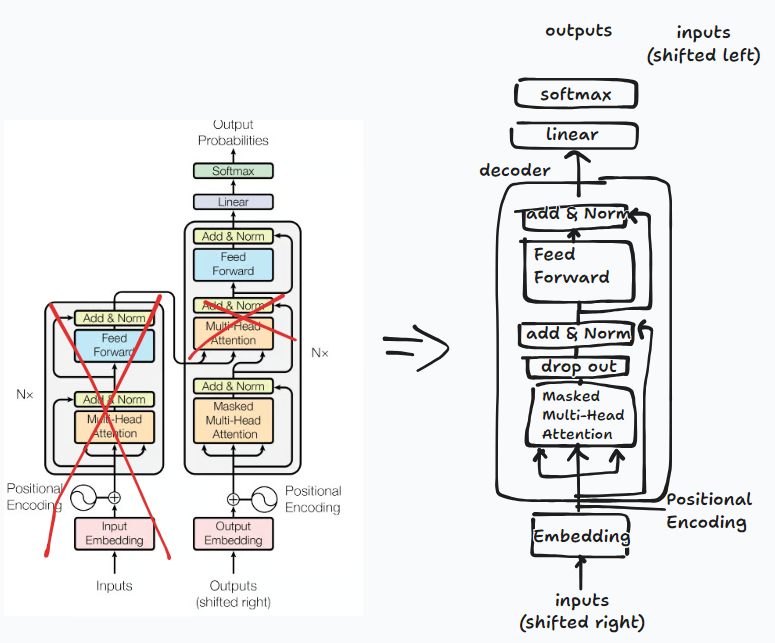

- 인코더 부분 삭제
- 입력 데이터는 input하나로 통일
- decoder 부분에서 교차 어텐션 제거

# Result
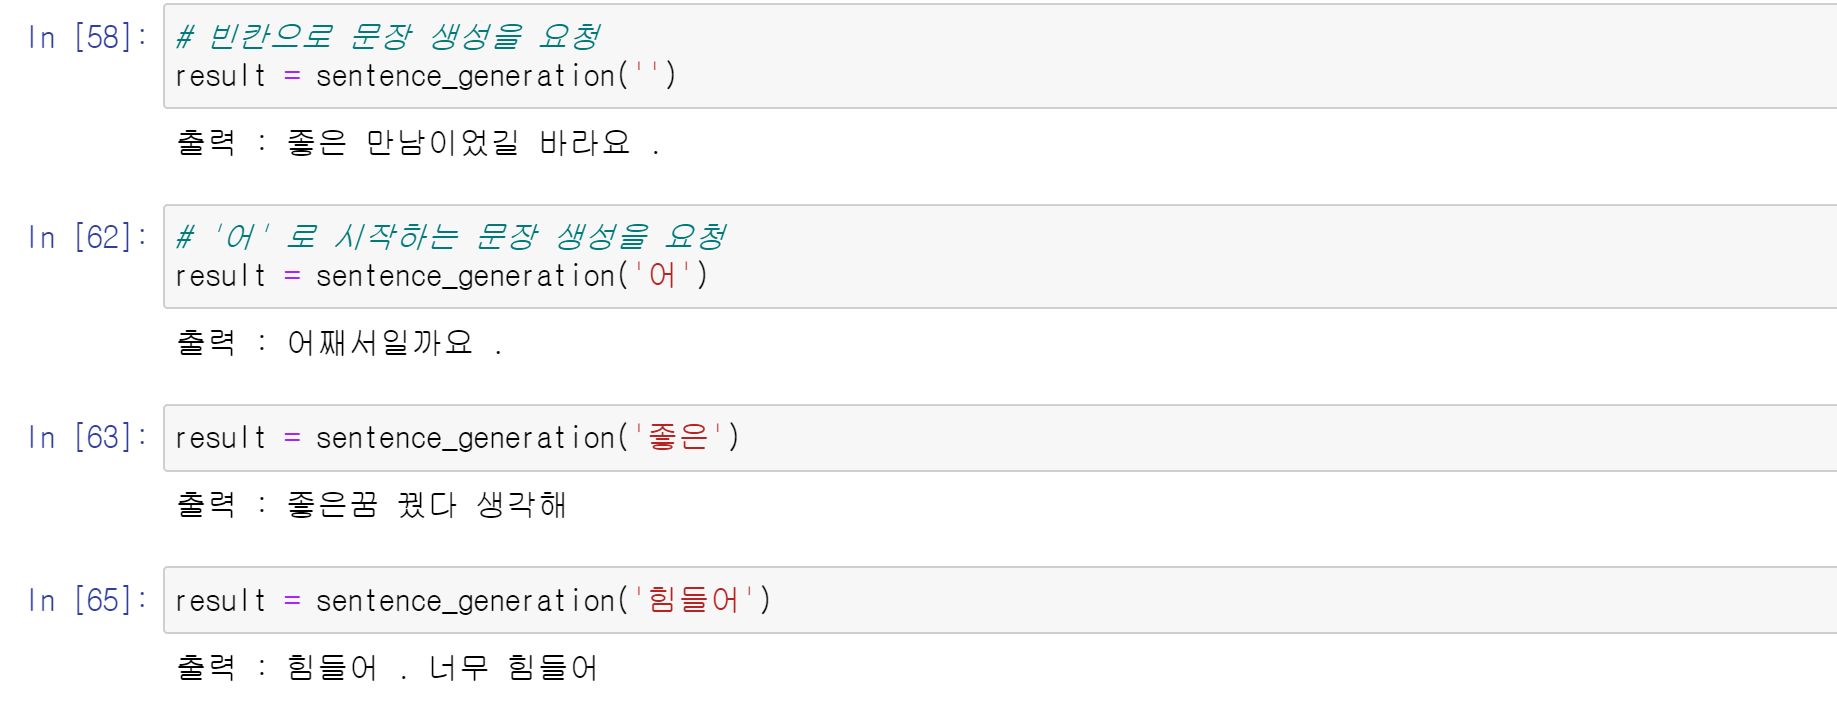

# model summary
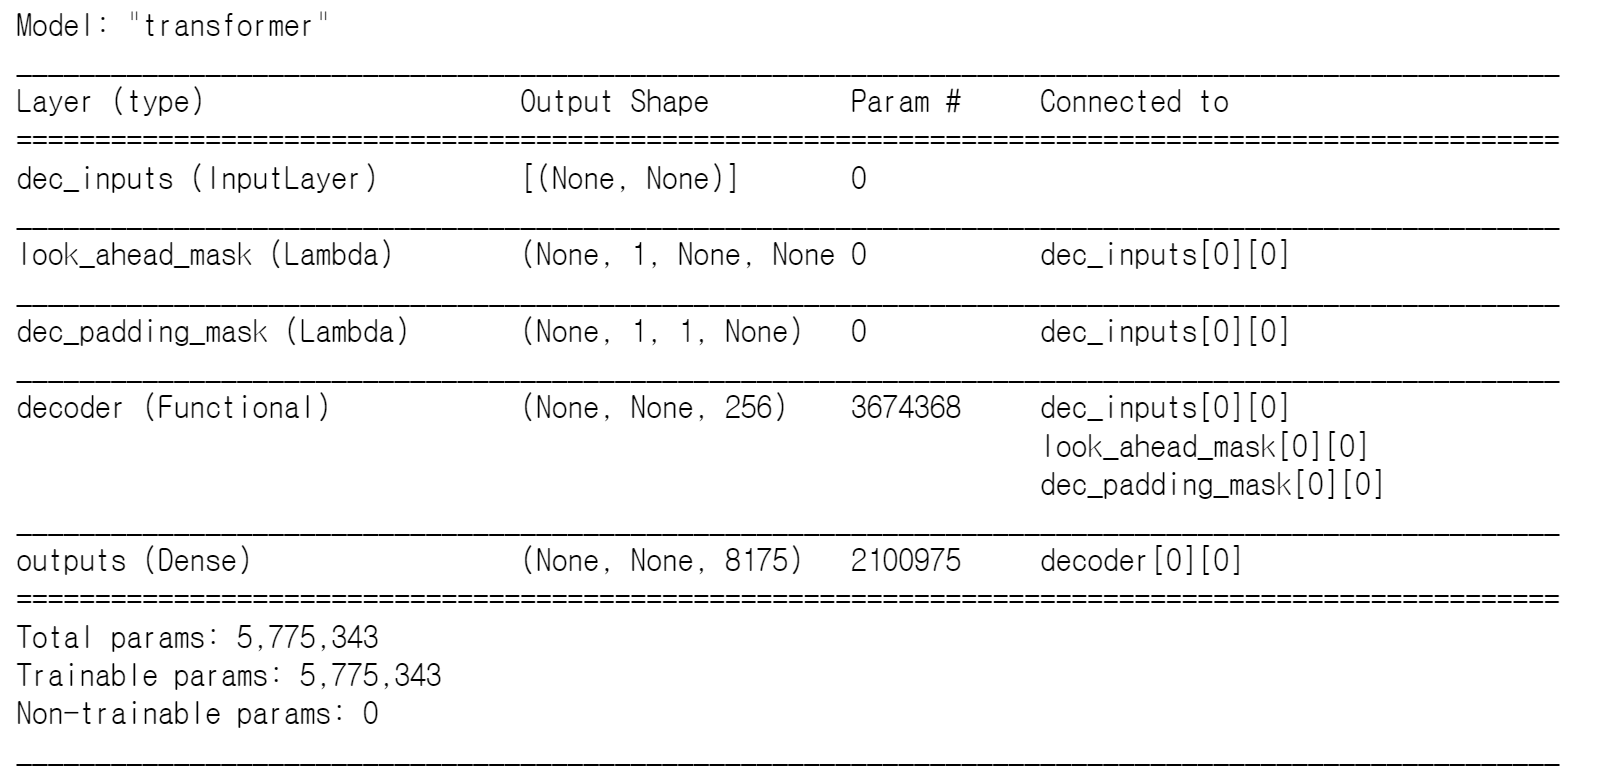

# model fit
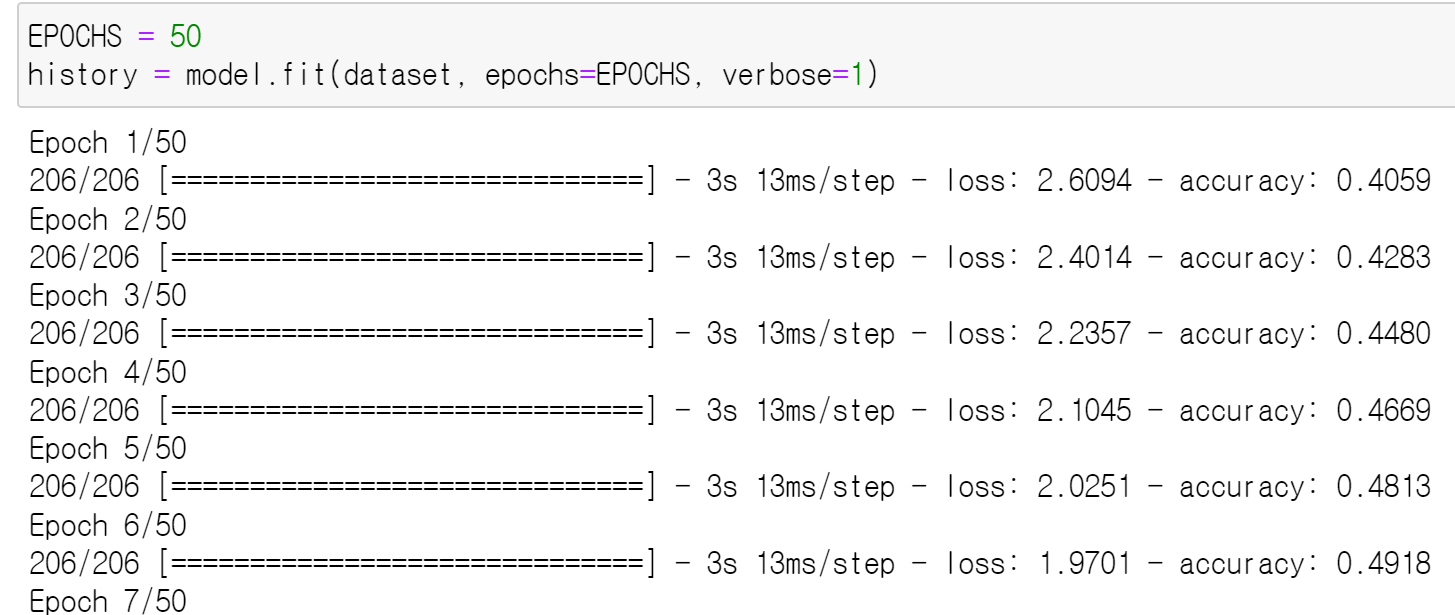
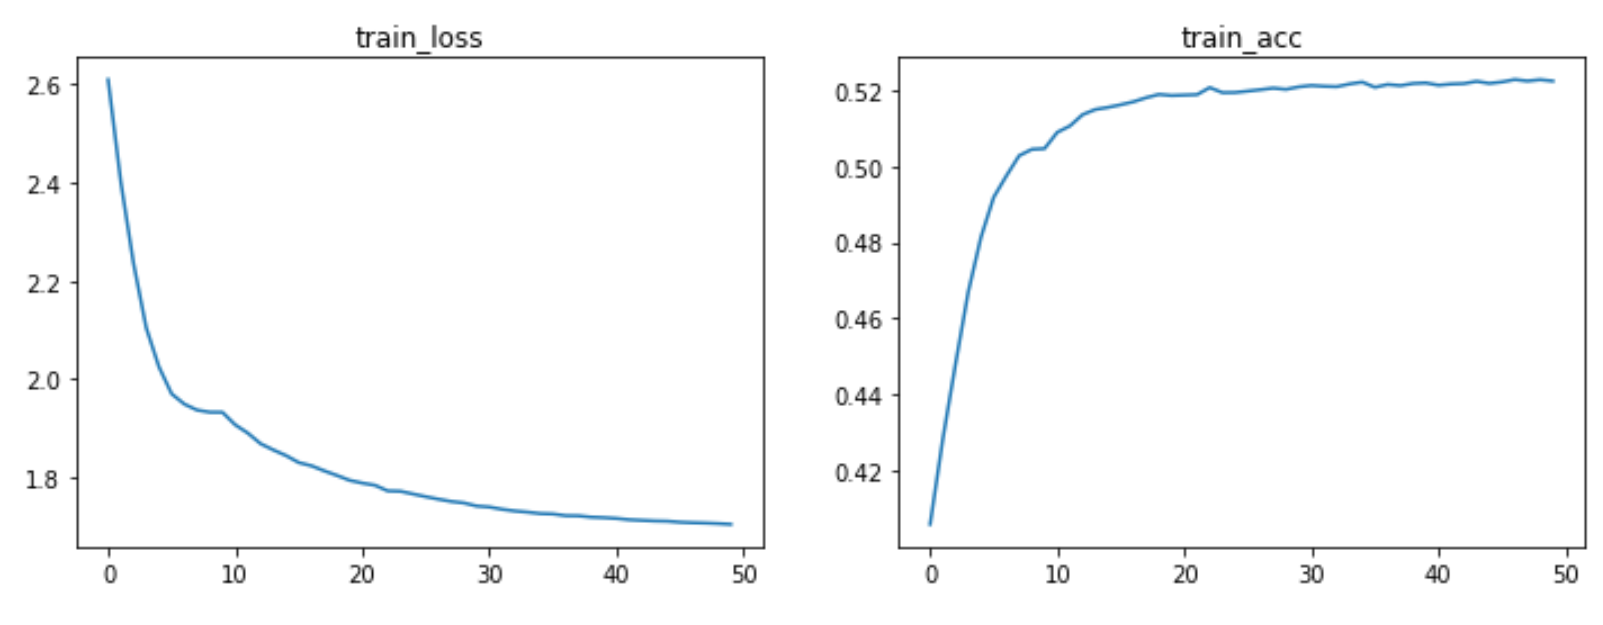

- 학습 곡선


### 추가 실험
- max_length는 성능에 영향을 줄까? (max_length 7 -> 20으로 변경)
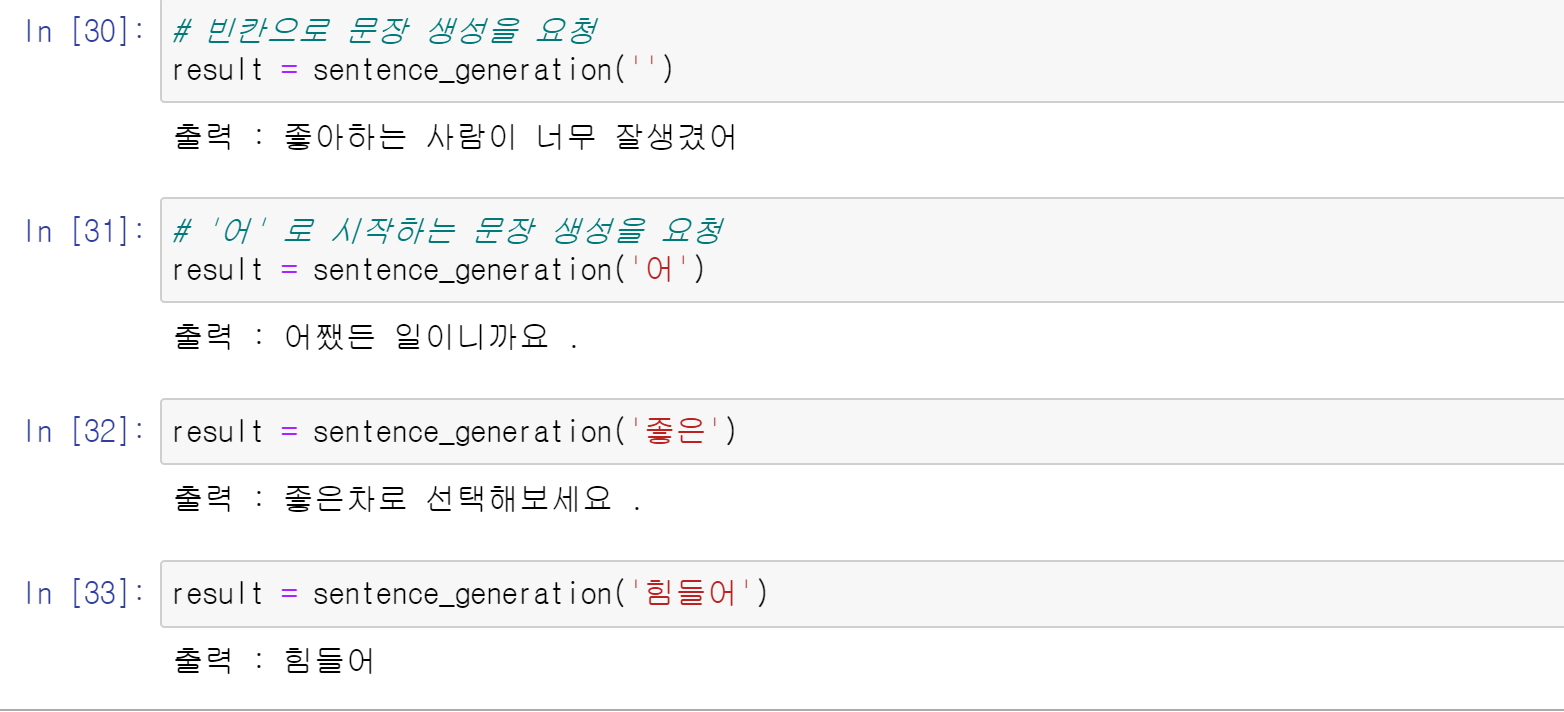

- 결과값이 비슷한 수준의 성능인것같다. 
- 성능에 영향을 주는건 decoder의 구조 차이인듯하다

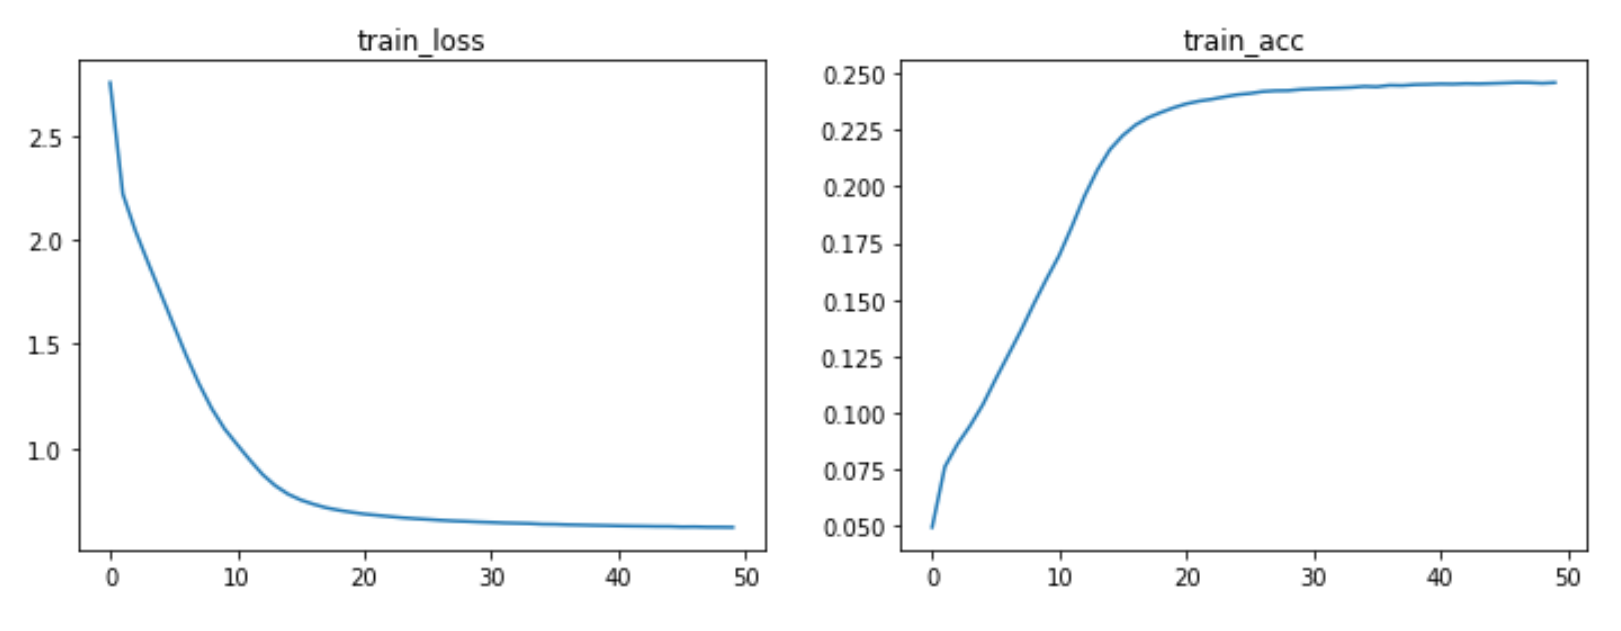

- loss로만 보면 훨씬 낮아졌다

# 회고
- 처음에 안녕을 쳤더니 계속 안녕안녕... 만 반복해서 놀랐다
- 일단 교차 어텐션을 아예 지워버리고 max_length를 줄여봤다
- 문제가 해결되었다
- max_length를 이제 늘리면 어떻게 될까 궁금했다


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow_datasets as tfds
import tensorflow as tf
import re
import matplotlib.pyplot as plt

# 데이터 준비

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/transformer_chatbot/data/ChatbotData.csv")

### 전처리

In [3]:
def preprocess_sentence(sentence):
    # 온점 사이에 공백을 넣기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 연속 공백을 하나의 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 큰따옴표를 제거
#     sentence = re.sub(r'["]', '', sentence)
    # 완성되지 않은 표현을 제거 (ㅜㅜ 또는 ㅇㅇ 같은 느낌)
#     sentence = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", "", sentence)
    # 양쪽 공백을 제거
    sentence = sentence.strip()
    return sentence

### 라벨링 안된 데이터셋을 만들기위해서 모든 구문을 합친다

In [4]:
def load_unlabel_dataset():
    inputs = []
    for i in range(len(data)):
        inputs.append(preprocess_sentence(data.iloc[i][0]))
        inputs.append(preprocess_sentence(data.iloc[i][1]))
    return inputs

In [5]:
inputs = load_unlabel_dataset()
print('전체 샘플 수 :', len(inputs))

전체 샘플 수 : 23646


### 토크나이징


In [6]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs, target_vocab_size=2**13)

In [7]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [8]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [9]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### max_length 결정후 패딩

In [10]:
# 저번 프로젝트 경험을 통해서 32로 결정
MAX_LENGTH = 20

def tokenize_and_filter(inputs):
    tokenized_inputs = []
  
    for sentence1 in inputs:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)

    # 최대 길이 35으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
        
    return tokenized_inputs

In [11]:
inputs_af = tokenize_and_filter(inputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(inputs_af)))

단어장의 크기 : 8175
필터링 후의 샘플 개수: 23614


### 교사 강요 데이터셋 제작

#### decoder의 input과 output을 만들어줌

In [12]:
inputs_af.shape

(23614, 20)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': inputs_af[:, :-1]
    },
    {
        'outputs': inputs_af[:, 1:]
    },
))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Transformer 모델 만들기

In [14]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [15]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [17]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## Decoder - layer
- 기존과 다르게 encoder는 불러오지 않는다
- ~~두번째 인코더-디코더 어텐션 진행시 기존 결과에 대한 셀프어텐션으로 진행~~ - decoder_layer 함수
    - 기존 교차 어텐션을 그대로 셀프 어텐션으로 바꿨더니 학습이 안되고 입력을 계속 반복하는 상태
- **인코더 - 디코더 교차 어텐션을 삭제함** - decoder_layer2 함수

In [18]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 셀프 - 어텐션 수행  (이부분을 지워버려도되나)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': attention1,
          'value': attention1,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        # 여기서 encoder_output 입력 삭제
        inputs=[inputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [19]:
def decoder_layer2(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        # 여기서 encoder_output 입력 삭제
        inputs=[inputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [20]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer2(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs,look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs,look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [21]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(dec_inputs)

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)

In [22]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3147008     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]  

# 모델 학습

In [23]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [26]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
369/369 [==============================] - 12s 23ms/step - loss: 2.7530 - accuracy: 0.0493
Epoch 2/50
369/369 [==============================] - 9s 23ms/step - loss: 2.2190 - accuracy: 0.0761
Epoch 3/50
369/369 [==============================] - 9s 23ms/step - loss: 2.0403 - accuracy: 0.0861
Epoch 4/50
369/369 [==============================] - 9s 23ms/step - loss: 1.8874 - accuracy: 0.0943
Epoch 5/50
369/369 [==============================] - 9s 23ms/step - loss: 1.7394 - accuracy: 0.1036
Epoch 6/50
369/369 [==============================] - 9s 23ms/step - loss: 1.5899 - accuracy: 0.1149
Epoch 7/50
369/369 [==============================] - 9s 23ms/step - loss: 1.4422 - accuracy: 0.1256
Epoch 8/50
369/369 [==============================] - 9s 23ms/step - loss: 1.3077 - accuracy: 0.1364
Epoch 9/50
369/369 [==============================] - 9s 24ms/step - loss: 1.1895 - accuracy: 0.1481
Epoch 10/50
369/369 [==============================] - 9s 24ms/step - loss: 1.0928 - accur

Text(0.5, 1.0, 'train_acc')

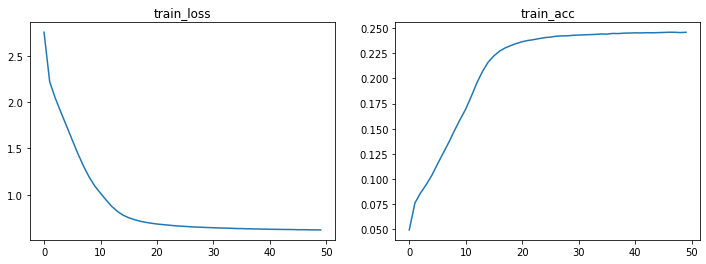

In [27]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].plot(history.history['loss'], label='train')
axs[0].set_title('train_loss')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].set_title('train_acc')

# decoder 출력값 
- 스타트 토큰만 넣어주면된다
- 또는 어떤 문장을 넣어주고 그 뒤를 이어서 말하게 하는 구조를 넣었다
    - input에 아무 단어를 안넣어도 된다
    - 어떤 문장을 넣는다면 그 이후로 답변을 한다

In [28]:
def decoder_inference(sentence):
    
    sentence = preprocess_sentence(sentence)
    output_sequence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence),0)
    
#     output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=output_sequence, training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [29]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [30]:
# 빈칸으로 문장 생성을 요청
result = sentence_generation('')

출력 : 좋아하는 사람이 너무 잘생겼어


In [31]:
# '어' 로 시작하는 문장 생성을 요청
result = sentence_generation('어')

출력 : 어쨌든 일이니까요 .


In [32]:
result = sentence_generation('좋은')

출력 : 좋은차로 선택해보세요 .


In [33]:
result = sentence_generation('힘들어')

출력 : 힘들어
